In [1]:
%load_ext autoreload
%autoreload 2

# SIM

In [2]:
from astropy import units as u
import numpy as np
from cmdstanpy import CmdStanModel
import arviz, corner
from matplotlib import pyplot as plt

import sys
sys.path.append("../../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s

In [3]:
# Choose simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
F_diff_norm = 1e-16 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [17]:
sim = Simulation(L, gamma, z, F_diff_norm, Emin, Emax, Enorm)
sim.run(seed=42)


Simulating 39 events...
Done!


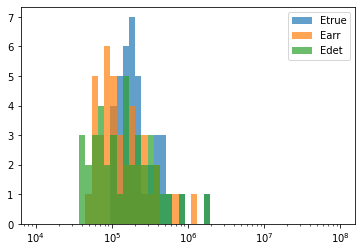

In [6]:
sim.show_spectrum()

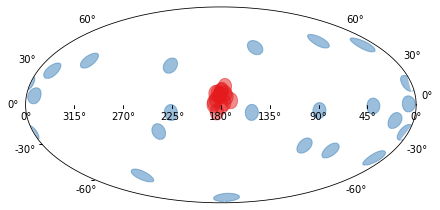

In [7]:
sim.show_skymap()

In [8]:
# Extract simulated data and get info needed for fit
fit_input = sim.data()

In [9]:
fit_input

OrderedDict([('N', 39),
             ('Edet',
              array([ 160494.5938574 ,  301492.05941278,   98365.02946014,
                      124559.60563702,  325742.64786662,  237575.94503549,
                       64972.13486349,   78925.11678329,  563612.79241109,
                       85148.29895773,  142051.42558954, 1883647.18745385,
                      217222.21262399,   40062.79683038,  450155.35016338,
                       70754.4930768 ,   41779.98531686,  161282.21348771,
                      370044.03861468,  352102.90081269,  280037.38660527,
                       85800.17352267,  172962.05588992,  106541.37394527,
                      373861.64327788,   97225.2783876 ,   73633.41710957,
                      139767.65205004,   50460.01545192,  197499.51009756,
                       76965.50518939,   59704.79626241,   51996.36306348,
                       56675.83399277,  240532.578054  ,  787206.48802644,
                       42041.08951639,  142836.1135131

# FQTIST FIT

In [20]:
bg_sim = Simulation(0*u.erg/u.s, gamma, z, F_diff_norm, Emin, Emax, Enorm, 1000)
bg_sim.run(seed=12345678)
bg_dat = bg_sim.get_data()

0.0 1 / (cm2 s)
8.331240094640408e-12 1 / (cm2 s)
[<Quantity 0.>, <Quantity 1.>]
1.0
Done!


AttributeError: 'Simulation' object has no attribute 'get_data'

In [19]:
import nu_stats.fqutils as fq

In [67]:
s_dir = np.reshape(fit_input['source_dir'],(1,3))
det_dir = fit_input['det_dir']
sim_TS = fq.test_stat(s_dir, det_dir, fit_input['kappa'])
bg_TS = fq.test_stat(s_dir, bg_dat['det_dir'], bg_dat['kappa'])

In [68]:
## get p values
sim_p = np.zeros_like(sim_TS)
for i,obs_TS in enumerate(sim_TS):
    sim_p[i] = (np.mean(bg_TS > obs_TS))
## set label 0 for p>=.01 and 1 for p<.01
labels = (sim_p <.01).astype(int)

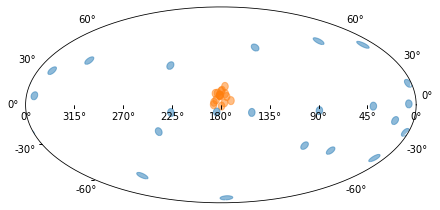

In [69]:
u_v_s(det_dir, labels);

In [70]:
bg_TS.sort()

In [71]:
frac = lambda x: np.mean(bg_TS > x)
y = np.array([frac(elem) for elem in bg_TS])

(array([252., 285., 271., 251., 271., 257., 263., 278., 223., 238.]),
 array([-830.65770229, -746.75947179, -662.86124128, -578.96301077,
        -495.06478026, -411.16654975, -327.26831924, -243.37008873,
        -159.47185823,  -75.57362772,    8.32460279]),
 <BarContainer object of 10 artists>)

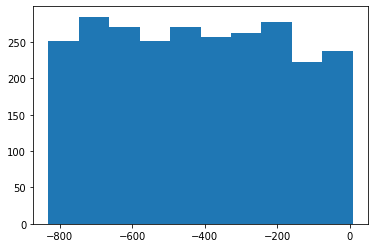

In [72]:
plt.hist(bg_TS)

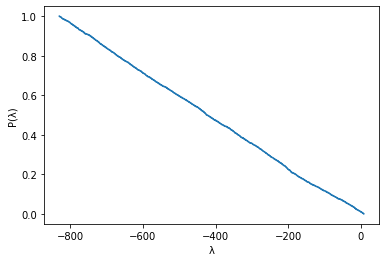

In [73]:

plt.step(bg_TS, y);
plt.xlabel('λ');
plt.ylabel('P(λ)');
#plt.yscale('log');

# BHM

In [7]:
stan_model = CmdStanModel(stan_file="stan/toy_bhm.stan")
fit = stan_model.sample(data=fit_input, iter_sampling=1000, chains=4, seed=42)

INFO:cmdstanpy:compiling stan program, exe file: /mnt/c/Users/minoz/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/mnt/c/Users/minoz/nu_stats/examples/bayes_hierarchical_model/stan']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /mnt/c/Users/minoz/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


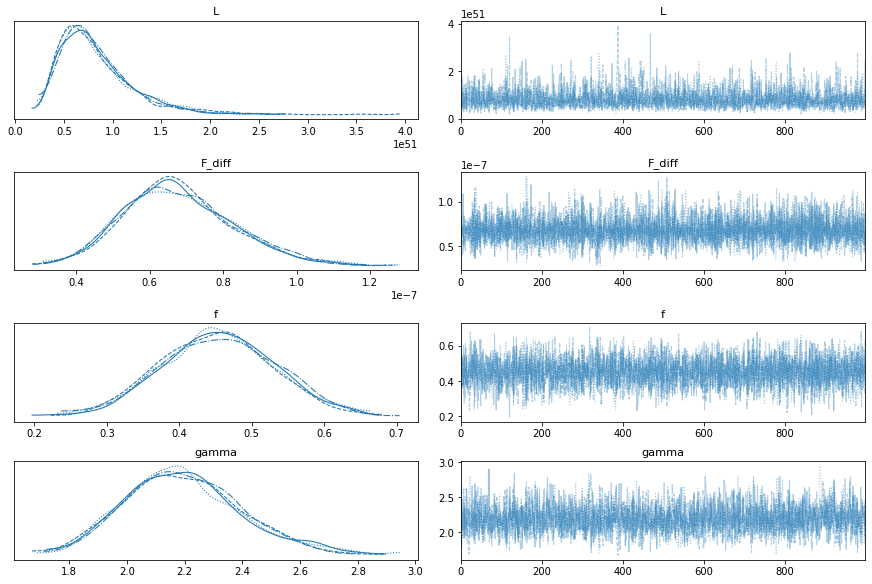

In [8]:
# Trace plot
var_names = ["L", "F_diff", "f", "gamma"]
arviz.plot_trace(fit, var_names=var_names);


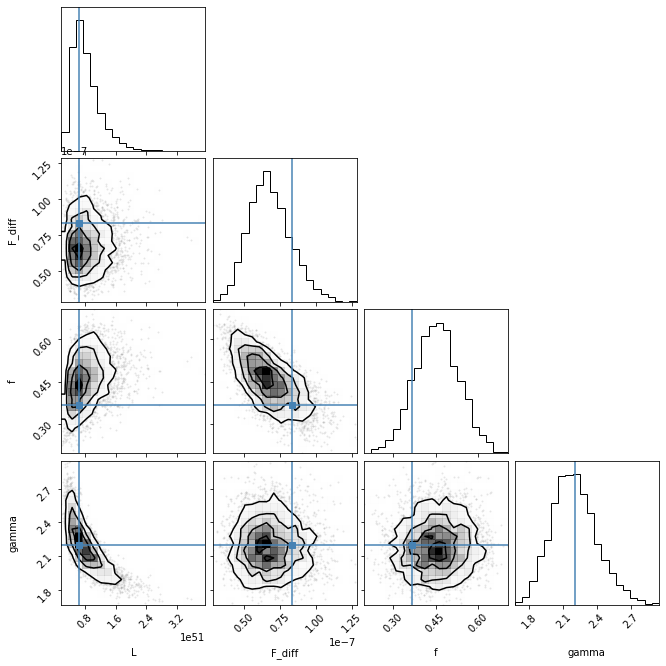

In [9]:
# Corner plot, comparing with truth form sim
chain = fit.stan_variables()
samples = np.column_stack([chain[key].values.T[0] for key in var_names])
truths_list = [sim.truth[key] for key in var_names]

corner.corner(samples, labels=var_names, truths=truths_list);